In [1]:
import tensorflow as tf
import numpy as np
import os
import time
import datetime
from tensorflow.contrib import learn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph('model-9500.meta')
saver.restore(sess,tf.train.latest_checkpoint('./'))

INFO:tensorflow:Restoring parameters from /Users/adb/Google Drive/Data Analytics/project/xtalkdb/Deep Learning/num_filter_64_fold_0/1512825696/checkpoints/model-9900


In [3]:
# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
graph = tf.get_default_graph()
# w1 = graph.get_tensor_by_name("w1:0")
# w2 = graph.get_tensor_by_name("w2:0")
# feed_dict ={w1:13.0,w2:17.0}
 
# #Now, access the op that you want to run. 
# op_to_restore = graph.get_tensor_by_name("op_to_restore:0")
 
# print sess.run(op_to_restore,feed_dict)

In [4]:
from utils import *

In [23]:
# Load data
x_text, y = load_data_and_labels()

# Build vocabulary
max_document_length = max([len(x.split(" ")) for x in x_text])
vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
x = np.array(list(vocab_processor.fit_transform(x_text)))
print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))


encodedPathwayA, encodedPathwayB = list(vocab_processor.transform(['pathwayA pathwayB']))[0][:2]
print("encodedPathwayA = %s" % encodedPathwayA, "encodedPathwayB = %s" % encodedPathwayB)

word_distancesA = load_word_distancesA()
word_distancesB = load_word_distancesB()

pos_embedding = load_pos_embedding()

Vocabulary Size: 33447
encodedPathwayA = 8 encodedPathwayB = 53


In [24]:
sess.graph.get_operations()

[<tf.Operation 'input_x' type=Placeholder>,
 <tf.Operation 'input_y' type=Placeholder>,
 <tf.Operation 'dropout_keep_prob' type=Placeholder>,
 <tf.Operation 'word_distancesA' type=Placeholder>,
 <tf.Operation 'word_distancesB' type=Placeholder>,
 <tf.Operation 'encoded_pos' type=Placeholder>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'word_embedding/random_uniform/shape' type=Const>,
 <tf.Operation 'word_embedding/random_uniform/min' type=Const>,
 <tf.Operation 'word_embedding/random_uniform/max' type=Const>,
 <tf.Operation 'word_embedding/random_uniform/RandomUniform' type=RandomUniform>,
 <tf.Operation 'word_embedding/random_uniform/sub' type=Sub>,
 <tf.Operation 'word_embedding/random_uniform/mul' type=Mul>,
 <tf.Operation 'word_embedding/random_uniform' type=Add>,
 <tf.Operation 'word_embedding/W' type=VariableV2>,
 <tf.Operation 'word_embedding/W/Assign' type=Assign>,
 <tf.Operation 'word_embedding/W/read' type=Identity>,
 <tf.Operation 'word_embedding/embedding_lookup' t

In [103]:

temp = sess.run(sess.graph.get_tensor_by_name('conv-maxpool-5/conv:0'), feed_dict = {
              input_x: x[:20],
              input_y: y[:20],
              dropout_keep_prob: 1.0,
              wA: word_distancesA[:20],
              wB: word_distancesB[:20],
              encoded_pos: pos_embedding[:20]
            })

In [223]:
def cnn_activation(conv_layer=3):
    input_x = sess.graph.get_tensor_by_name('input_x:0')
    input_y = sess.graph.get_tensor_by_name('input_y:0')
    dropout_keep_prob = sess.graph.get_tensor_by_name('dropout_keep_prob:0')
    wA = sess.graph.get_tensor_by_name('word_distancesA:0')
    wB = sess.graph.get_tensor_by_name('word_distancesB:0')
    encoded_pos = sess.graph.get_tensor_by_name('encoded_pos:0')

    temp = sess.run(sess.graph.get_tensor_by_name('conv-maxpool-%s/conv:0' % conv_layer), feed_dict = {
              input_x: x[:1500],
              input_y: y[:1500],
              dropout_keep_prob: 1.0,
              wA: word_distancesA[:1500],
              wB: word_distancesB[:1500],
              encoded_pos: pos_embedding[:1500]
            })
    
    temp1 = np.squeeze(np.mean(temp, axis=3))
    wmin = np.min(temp1, axis=1)
    wmax = np.max(temp1, axis=1)
    temp2 = (temp1.transpose() - wmin)/(wmax-wmin)
    temp2 = temp2.transpose()
    temp3 = np.zeros([temp.shape[0], 273])
    for i in range(temp2.shape[1]):
        temp3[:,i:i+3] += temp2[:,i].reshape([temp.shape[0],1])
    temp3 = temp3/(273-temp2.shape[1]+1)
    return temp3

def predict():
    input_x = sess.graph.get_tensor_by_name('input_x:0')
    input_y = sess.graph.get_tensor_by_name('input_y:0')
    dropout_keep_prob = sess.graph.get_tensor_by_name('dropout_keep_prob:0')
    wA = sess.graph.get_tensor_by_name('word_distancesA:0')
    wB = sess.graph.get_tensor_by_name('word_distancesB:0')
    encoded_pos = sess.graph.get_tensor_by_name('encoded_pos:0')

    return sess.run(sess.graph.get_tensor_by_name('output/predictions:0'), feed_dict = {
              input_x: x[:1500],
              input_y: y[:1500],
              dropout_keep_prob: 1.0,
              wA: word_distancesA[:1500],
              wB: word_distancesB[:1500],
              encoded_pos: pos_embedding[:1500]
            })
    

In [224]:
conv3 = cnn_activation(conv_layer=3)
conv4 = cnn_activation(conv_layer=4)
conv5 = cnn_activation(conv_layer=5)
avg_conv = (conv3+conv4+conv5)/3

In [225]:
output = predict()

In [226]:
output

array([1, 1, 1, ..., 0, 0, 0])

In [230]:
actual = np.argmax(y, axis=1)

In [238]:
def display_activation(activations, x_text=x_text, n=10):
    my_cmap = mpl.cm.YlOrBr
    fig, ax = plt.subplots()
    for j in range(n):
        words = x_text[j].split()
        for i in range(len(words)):
            num_words = len(words)
            ax.text(j/3,1-i/num_words*2, words[i], color=my_cmap(activations[j][i]), zorder=0)
        ax.text(j/3, 1.3, 'supportive' if actual[j] == 1 else 'non-supportive')
    # For the moment, hide everything else...
    ax.axis('off')

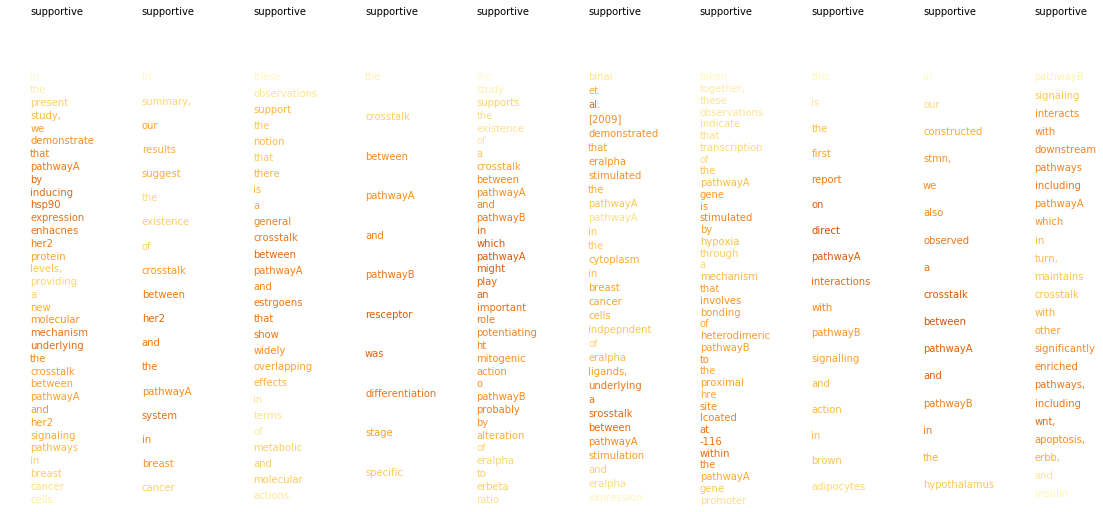

In [239]:
display_activation(avg_conv)

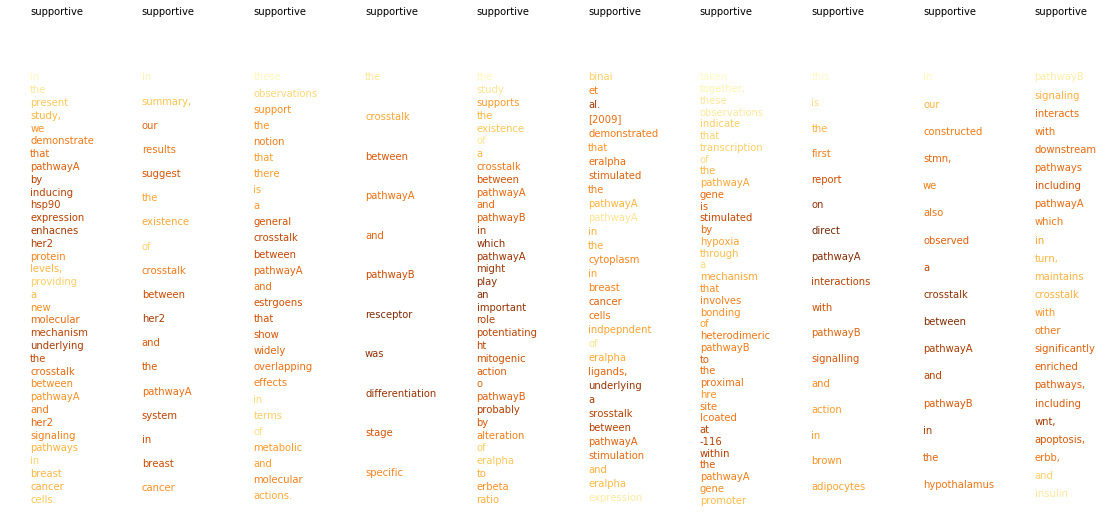

In [240]:
display_activation(conv3)

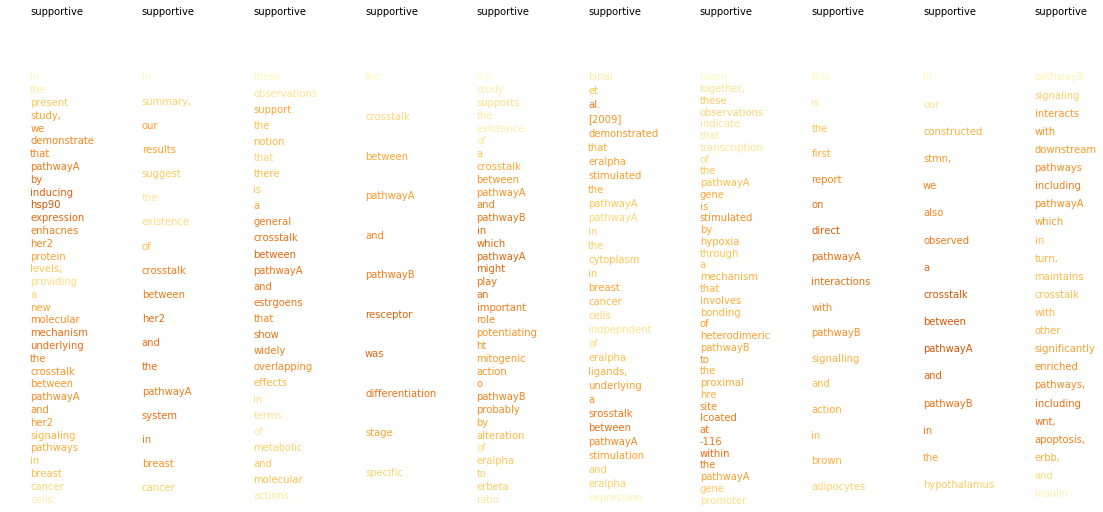

In [241]:
display_activation(conv4)

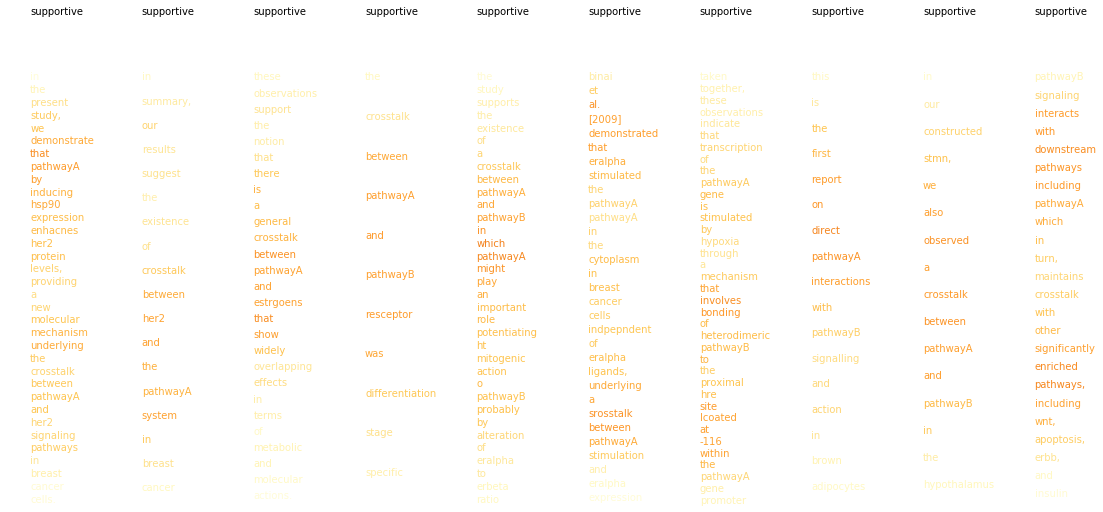

In [242]:
display_activation(conv5)